In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

### func

### data

In [2]:
df = pd.read_csv("taxis.csv")
print(f"{df.shape = }")
df.head()

df.shape = (6433, 14)


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


In [3]:
df['pickup_time_braket'] = pd.to_datetime(df['pickup']).dt.hour // 2
df['dropoff_time_braket'] = pd.to_datetime(df['dropoff']).dt.hour // 2

_ = pd.Categorical(df['pickup_borough'])
_ = pd.Categorical(df['dropoff_borough'])
df['pickup_borough_code'] = pd.Categorical(df['pickup_borough']).codes
df['dropoff_borough_code'] = pd.Categorical(df['dropoff_borough']).codes

In [4]:
col_from, col_to = "pickup_time_braket", "dropoff_time_braket"

In [70]:
from_vals = sorted(df[col_from].unique())
to_vals = sorted(df[col_to].unique())

spine = pd.MultiIndex.from_product(
    [from_vals, to_vals],
    names=[col_from, col_to]
).to_frame(index=False)
spine

,pickup_time_braket,dropoff_time_braket
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
139,11,7
140,11,8
141,11,9
142,11,10


In [74]:
gdf = (
    df
    .loc[lambda x: x[col_from].isin([9,10,11]),:]
    .groupby([col_from, col_to], dropna=False, observed=False, as_index=False)
    .agg(
        **{
            "n": (col_from, "size"),
            'tip': (col_from, lambda x: df.loc[x.index, 'tip'].sum()/df.loc[x.index, 'fare'].sum()),
        }
    )
)
gdf = spine.merge(gdf, on=[col_from, col_to], how="left")

gdf

,pickup_time_braket,dropoff_time_braket,n,tip
0,0,0,NaN,NaN
1,0,1,NaN,NaN
2,0,2,NaN,NaN
3,0,3,NaN,NaN
4,0,4,NaN,NaN
...,...,...,...,...
139,11,7,NaN,NaN
140,11,8,NaN,NaN
141,11,9,NaN,NaN
142,11,10,NaN,NaN


In [75]:
pdf = gdf.pivot_table(index=col_from, columns=col_to, values="n", fill_value=0, dropna=False)
pdf.head()

dropoff_time_braket,0,1,2,3,4,5,6,7,8,9,10,11
pickup_time_braket,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
pdf_color_tip = gdf.pivot_table(index=col_from, columns=col_to, values="tip", fill_value=0, dropna=False)
pdf_color_tip.head()

dropoff_time_braket,0,1,2,3,4,5,6,7,8,9,10,11
pickup_time_braket,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
pdf_color_horizontal_pct = pdf.div(pdf.sum(axis=1), axis=0)
pdf_color_horizontal_pct

dropoff_time_braket,0,1,2,3,4,5,6,7,8,9,10,11
pickup_time_braket,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### plot

In [78]:
from matplotlib import ticker as mticker

def plot_transition_matrix(
    transition_matrix_df: pd.DataFrame,
    color_transition_matrix_df: pd.DataFrame = None,
    title="",
    display_transition_rates=True,
    ax=None,
    figsize=(6, 5),
    fontsize=5,
    colorbar_label=None,
):

    def text_formatter(x):
        if x == 0:
            return ""
        else:
            return f"{x:.0f}"

    def pct_formatter(x):
        if x == 0:
            return ""
        else:
            return f"{x:.2%}"

    pdf = transition_matrix_df.copy()
    pdf_color = color_transition_matrix_df.copy() if color_transition_matrix_df is not None else pdf.div(pdf.sum(axis=1), axis=0)
    assert pdf.shape == pdf_color.shape, f"Transition matrix and color transition matrix must have the same shape, they are: {pdf.shape} vs {pdf_color.shape}"

    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    else:
        fig = ax.figure

    yticks, yticklabels, ylabel = range(len(pdf.index)), pdf.index, pdf.index.name
    xticks, xticklabels, xlabel = range(len(pdf.columns)), pdf.columns, pdf.columns.name

    cax = ax.imshow(pdf_color.values, cmap="Blues")
    color_threshold = pdf_color.values.max() / 2

    for i in yticks:
        for j in xticks:
            color_value = pdf_color.values[i, j]
            text_color = "white" if color_value > color_threshold else "black"

            va = "bottom" if display_transition_rates else "center"
            ax.text(j, i, text_formatter(pdf.iloc[i, j]), ha="center", va=va, color=text_color, fontsize=fontsize)

            if display_transition_rates:
                ax.text(j, i, pct_formatter(color_value), ha="center", va="top", color=text_color, fontsize=fontsize)

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel(ylabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel(xlabel)

    ax.set_title(title)

    # Add minor ticks at halfway points
    ax.set_xticks(np.arange(-0.5, len(xticks), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(yticks), 1), minor=True)

    # Show grid at minor ticks (halfway points between cells)
    ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

    if colorbar_label:
        fig.colorbar(
            cax, 
            label=colorbar_label,
            format=mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%"), 
            orientation="vertical", pad=0.02
        )

    return fig, ax


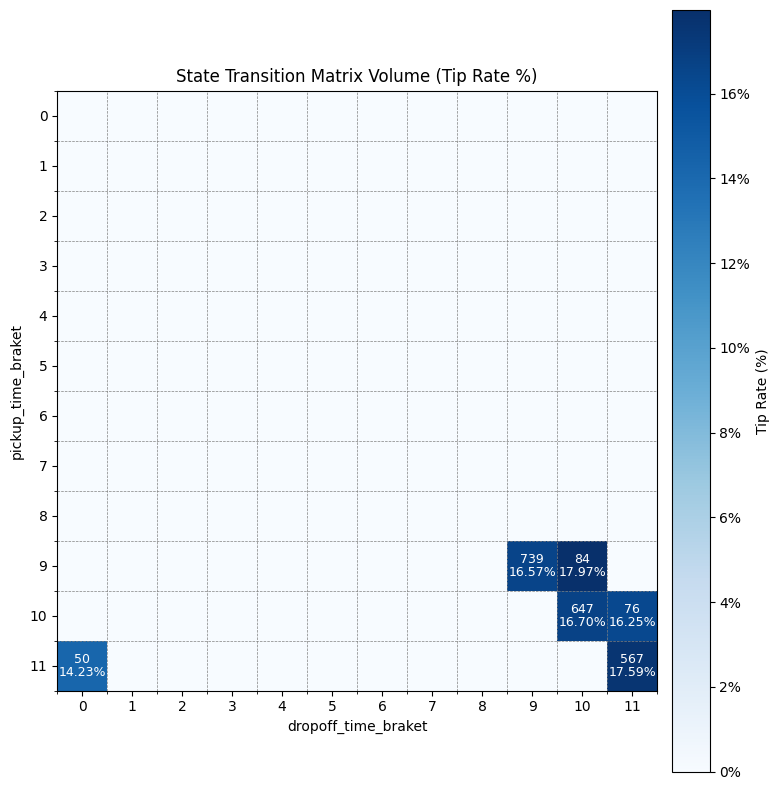

In [79]:
plot_transition_matrix(
    transition_matrix_df=pdf,
    color_transition_matrix_df=pdf_color_tip,
    title="State Transition Matrix Volume (Tip Rate %)",
    display_transition_rates=True,
    ax=None,
    figsize=(8, 8),
    fontsize=9,
    colorbar_label="Tip Rate (%)"
)

plt.tight_layout()